<a href="https://colab.research.google.com/github/bingyulab/boolean/blob/main/Boolean_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
try:
    from deap import base, creator, tools, gp
except ImportError:
    ! pip3 install git+https://github.com/DEAP/deap@master
    !apt-get install -y libtinfo5
    from deap import base, creator, tools, gp

try:
    import pyboolnet.file_exchange as FileExchange
    import pyboolnet.interaction_graphs as IG
    import pyboolnet.attractors as Attractors
    import pyboolnet.state_transition_graphs as STGs
    from pyboolnet.repository import get_primes
    from pyboolnet.file_exchange import bnet2primes
    from pyboolnet.prime_implicants import create_variables
except ImportError:
    ! pip3 install git+https://github.com/hklarner/pyboolnet@master
    import pyboolnet.file_exchange as FileExchange
    import pyboolnet.interaction_graphs as IG
    import pyboolnet.attractors as Attractors
    import pyboolnet.state_transition_graphs as STGs
    from pyboolnet.repository import get_primes
    from pyboolnet.file_exchange import bnet2primes
    from pyboolnet.prime_implicants import create_variables

import operator
import random
import itertools
import re
from copy import deepcopy
import math
import time

try:
    import cairosvg
    import igraph as ig
except ImportError:
    !apt-get install graphviz libgraphviz-dev pkg-config
    ! pip3 install pydot igraph cairosvg pygraphviz
    import cairosvg
    import igraph as ig

import matplotlib.pyplot as plt
from PIL import Image
import os

import tempfile
import numpy as np
import matplotlib.image as mpimg

from multiprocessing import Pool

from sympy import symbols
from sympy.parsing.sympy_parser import parse_expr
from sympy.logic.boolalg import to_anf

In [25]:
model_name             = 'davidich_yeast' # faure_cellcycle xiao_wnt5a davidich_yeast

# Tunable weights
DYN_WEIGHT             = 1.0   # each attractor match ∈ [0,1], summed
COVERAGE_WEIGHT        = 2.0   # reduced from 5.0
CONN_WEIGHT_PER_VAR    = 0.05   # per extra variable beyond 1
LENGTH_PENALTY_COEF    = 0.1   # stronger penalty for long trees
OPS_PENALTY_COEF       = 0.05   # stronger penalty on operators
DISCONNECT_PENALTY     = 50

SAMPLE_RATE            = 0.6

nodes_to_evolve        = ['x2'] if model_name == 'xiao_wnt5a' else ['Cdc25', 'Rum1', 'SK', 'Slp1']
generations            = 15
population_size        = 100

In [26]:
# Load or define a partial Boolean
primes = get_primes(model_name)
# STGs.create_stg_image(primes, "asynchronous", "stg_asynchronous.svg")
STGs.create_stg_image(primes, "synchronous",  "stg_synchronous.svg")

def display_pdf_as_image(pdf_path):
    png_path = pdf_path.replace(".svg", ".png")
    cairosvg.svg2png(url=pdf_path, write_to=png_path)
    img = Image.open(png_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Display both graphs
# display_pdf_as_image("stg_asynchronous.svg")
# display_pdf_as_image("stg_synchronous.svg")

In [27]:
VARIABLE_NAMES = list(primes.keys())
Cdc25, Cdc2_Cdc13, Cdc2_Cdc13_A, PP, Rum1, SK, Slp1, Start, Ste9, Wee1_Mik1 = symbols(" ".join(VARIABLE_NAMES))
VARIABLE_NAMES = list(primes.keys())

desired_order = ["Start", "Sk", "Cdc2_Cdc13", "Ste9", "Rum1", "Slp1", "Cdc2_Cdc13A", "Wee1_Mik1", "Cdc25 PP"]
def custom_sort_key(variable_name):
    try:
        return desired_order.index(variable_name)
    except ValueError:
        # Put variables not in desired_order at the end
        return len(desired_order)

VARIABLE_NAMES.sort(key=custom_sort_key)

print("Sorted VARIABLE_NAMES:", VARIABLE_NAMES)

Sorted VARIABLE_NAMES: ['Start', 'Cdc2_Cdc13', 'Ste9', 'Rum1', 'Slp1', 'Wee1_Mik1', 'Cdc25', 'Cdc2_Cdc13_A', 'PP', 'SK']


In [28]:
def display_svg_file(svg_path):
    """Display an SVG file using matplotlib"""
    if not os.path.exists(svg_path):
        print(f"File {svg_path} does not exist. Skipping visualization.")
        return
    name = svg_path.split('.')[0]
    cairosvg.svg2png(url=f"{name}.svg", write_to=f"{name}.png")
    # Display the PNG image
    img = Image.open(f"{name}.png")
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

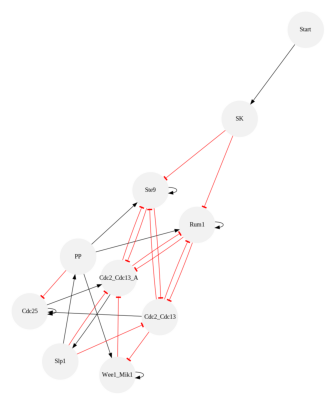

In [29]:
IG.create_image(primes, "igraph.svg")
display_svg_file("igraph.svg")

Think of the Boolean network as a dynamic system where each node (e.g., gene, protein) is either ON (`1`) or OFF (`0`), and their states update over time according to Boolean rules (like `x1 = x2 AND NOT x3`).

As the system evolves step by step, it moves through **states** (combinations of ON/OFF values). Eventually, it will either:

* Fall into a **fixed point** (a state that never changes),
* or enter a **cycle** of repeating states.

These **fixed points or cycles** are called **attractors**.

In [30]:
# Define your desired attractors or behaviors
if model_name == 'davidich_yeast':
    steady_attractors = [i["state"]['dict'] for i in Attractors.compute_attractors(primes, "synchronous")["attractors"]]
elif model_name == 'xiao_wnt5a':
    steady_attractors = [
        {"x1":0, "x2":1, "x3":0, "x4":1, "x5":1, "x6":1, "x7":1},  # 0101111
        {"x1":0, "x2":1, "x3":1, "x4":0, "x5":1, "x6":1, "x7":0},  # 0110110
        {"x1":0, "x2":1, "x3":1, "x4":1, "x5":1, "x6":1, "x7":0},  # 0111110
        {"x1":1, "x2":0, "x3":0, "x4":0, "x5":0, "x6":0, "x7":1},  # 1000001
    ]

elif model_name == 'faure_cellcycle':
    steady_attractors = [
    {"Cdc20":0, "CycA":0, "CycB":0, "CycD":0, "CycE":0, "E2F":0, "Rb":1, "UbcH10":0, "cdh1":1, "p27":1},  # 0000001011
  ]


target_attractors = steady_attractors[: math.ceil(len(steady_attractors) * SAMPLE_RATE)]
print(f"Sample size is: {len(target_attractors)}")
# target_attractors

Sample size is: 8


In [31]:
def binary_string_to_dict(binary_string, keys):
    """
    Transforms a binary string into a dictionary using a list of keys.

    Args:
        binary_string (str): The input string containing only '0's and '1's.
        keys (list): A list of strings to be used as keys in the output dictionary.

    Returns:
        dict: A dictionary where keys are from the 'keys' list and values
              are the integer equivalents of the characters in 'binary_string'.
              Returns an empty dictionary if the lengths don't match.
    """
    if len(binary_string) != len(keys):
        print("Error: The length of the binary string and the keys list do not match.")
        return {}

    output_dict = {}
    for key, value_char in zip(keys, binary_string):
        output_dict[key] = int(value_char)

    return output_dict

initial_state = ["0100101111", "0011000001", "0010100001", "0011100001", "0101000110",
                 "0100100001", "0011000011", "0010100011", "0011100011"]

initial_attractors = []
for i in range(len(initial_state)):
    initial_attractors.append(binary_string_to_dict(initial_state[i], VARIABLE_NAMES))
# initial_attractors

In [32]:
boolean_model = {
"Cdc25":         """OR(AND(NOT(PP), Cdc2_Cdc13),AND(NOT(PP), Cdc25),AND(Cdc2_Cdc13, Cdc25))""",
"Cdc2_Cdc13":    """AND(NOT(Ste9), NOT(Slp1), NOT(Rum1))""",
"Cdc2_Cdc13_A":  """AND(NOT(Wee1_Mik1), NOT(Ste9), NOT(Slp1), NOT(Rum1),Cdc25)""",
"PP":            "Slp1",
"Rum1":          """OR(AND(NOT(SK), Rum1, PP, NOT(Cdc2_Cdc13_A)), AND(NOT(SK), Rum1, PP, NOT(Cdc2_Cdc13)), AND(NOT(SK), Rum1, NOT(Cdc2_Cdc13_A), NOT(Cdc2_Cdc13)), AND(NOT(SK), PP, NOT(Cdc2_Cdc13_A), NOT(Cdc2_Cdc13)), AND(Rum1, PP, NOT(Cdc2_Cdc13_A), NOT(Cdc2_Cdc13)))""",
"SK":            "Start",
"Slp1":          "Cdc2_Cdc13_A",
"Ste9":          """OR(AND( Ste9, NOT(SK), PP, NOT(Cdc2_Cdc13_A)), AND( Ste9, NOT(SK), PP, NOT(Cdc2_Cdc13)), AND( Ste9, NOT(SK), NOT(Cdc2_Cdc13_A), NOT(Cdc2_Cdc13)), AND( Ste9, PP, NOT(Cdc2_Cdc13_A), NOT(Cdc2_Cdc13)), AND(NOT(SK),  PP, NOT(Cdc2_Cdc13_A), NOT(Cdc2_Cdc13)))""",
"Wee1_Mik1":     """OR(AND(Wee1_Mik1, PP), AND(Wee1_Mik1, NOT(Cdc2_Cdc13)), AND(PP, NOT(Cdc2_Cdc13)))"""}
boolean_model

{'Cdc25': 'OR(AND(NOT(PP), Cdc2_Cdc13),AND(NOT(PP), Cdc25),AND(Cdc2_Cdc13, Cdc25))',
 'Cdc2_Cdc13': 'AND(NOT(Ste9), NOT(Slp1), NOT(Rum1))',
 'Cdc2_Cdc13_A': 'AND(NOT(Wee1_Mik1), NOT(Ste9), NOT(Slp1), NOT(Rum1),Cdc25)',
 'PP': 'Slp1',
 'Rum1': 'OR(AND(NOT(SK), Rum1, PP, NOT(Cdc2_Cdc13_A)), AND(NOT(SK), Rum1, PP, NOT(Cdc2_Cdc13)), AND(NOT(SK), Rum1, NOT(Cdc2_Cdc13_A), NOT(Cdc2_Cdc13)), AND(NOT(SK), PP, NOT(Cdc2_Cdc13_A), NOT(Cdc2_Cdc13)), AND(Rum1, PP, NOT(Cdc2_Cdc13_A), NOT(Cdc2_Cdc13)))',
 'SK': 'Start',
 'Slp1': 'Cdc2_Cdc13_A',
 'Ste9': 'OR(AND( Ste9, NOT(SK), PP, NOT(Cdc2_Cdc13_A)), AND( Ste9, NOT(SK), PP, NOT(Cdc2_Cdc13)), AND( Ste9, NOT(SK), NOT(Cdc2_Cdc13_A), NOT(Cdc2_Cdc13)), AND( Ste9, PP, NOT(Cdc2_Cdc13_A), NOT(Cdc2_Cdc13)), AND(NOT(SK),  PP, NOT(Cdc2_Cdc13_A), NOT(Cdc2_Cdc13)))',
 'Wee1_Mik1': 'OR(AND(Wee1_Mik1, PP), AND(Wee1_Mik1, NOT(Cdc2_Cdc13)), AND(PP, NOT(Cdc2_Cdc13)))'}

In [33]:
# Define symbolic functions for GP
def AND(a, b): return a and b
def OR(a, b): return a or b
def NOT(a): return not a

In [34]:
n = len(target_attractors[0])
print(f"There are {n} nodes")
pset = gp.PrimitiveSetTyped("MAIN", [bool] * n, bool)
pset.addPrimitive(AND, [bool, bool], bool)
pset.addPrimitive(OR, [bool, bool], bool)
pset.addPrimitive(NOT, [bool], bool)
for i, name in enumerate(list(primes.keys())): pset.renameArguments(**{f"ARG{i}": f"{name}"})

There are 10 nodes


In [35]:
# - `FitnessMax`: Defines a fitness class for maximization problems (indicated by positive weights)
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
# - `Individual`: Creates a class based on `gp.PrimitiveTree` (which represents programs as trees)
# with a fitness attribute
# creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)
creator.create("Individual", list, fitness=creator.FitnessMax)

# The toolbox is DEAP's container for all operators used in the evolutionary process:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_= int(n * 0.4))

# - `expr`: Creates random tree expressions with depths between 2-6 using the "half and half" method
# The "half and half" method is a popular approach for generating the initial population in genetic programming. It combines two tree generation strategies:
# 1. **Grow method**: Creates trees with varying shapes by randomly selecting nodes from both function and terminal sets at each level, up to a maximum depth. This produces more irregular, potentially shallower trees.
# 2. **Full method**: Creates "full" trees by selecting only function nodes until reaching one level before the maximum depth, then only using terminal nodes at the maximum depth. This creates balanced trees that all reach the maximum depth.
# The "half and half" initialization typically:
# - Creates roughly 50% of the initial population using the grow method
# - Creates roughly 50% using the full method
# This approach ensures good genetic diversity in the initial population by including trees with different structures and shapes, which helps the evolutionary process explore the solution space more effectively.

# Mixed initialization: half full, half grow for diversity
# toolbox.register("expr_full", gp.genFull, pset=pset, min_=2, max_=4)
# toolbox.register("expr_grow", gp.genGrow, pset=pset, min_=2, max_=4)
# def init_ind():
#     if random.random() < 0.5:
#         return creator.Individual(toolbox.expr_full())
#     return creator.Individual(toolbox.expr_grow())
# toolbox.register("individual", init_ind)


# - `mate`: One-point crossover that swaps subtrees between individuals
# toolbox.register("mate", gp.cxOnePoint)
toolbox.register("mate_tree", gp.cxOnePoint)
# - `mutate`: Uniform mutation that replaces random subtrees with new ones
# toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr, pset=pset)
toolbox.register("mutate_tree", gp.mutUniform, expr=toolbox.expr, pset=pset)
# - `select`: Tournament selection with size 3 (selects best individual from 3 random choices)
toolbox.register("select", tools.selTournament, tournsize=3)

def init_multinode_ind():
    trees = []
    for _ in nodes_to_evolve:
        # expr() returns a sequence-of-nodes; wrapping it in gp.PrimitiveTree
        # gives you a true tree object
        tree = gp.PrimitiveTree(toolbox.expr())
        trees.append(tree)
    return creator.Individual(trees)

toolbox.register("individual", init_multinode_ind)


# - `population`: Creates a list of individuals
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


boolean_model = {k: gp.PrimitiveTree.from_string(v, pset) for k, v in boolean_model.items()}
# Define mate/mutate over the *list* of trees:
def mate_ind(ind1, ind2, prob):
    # for each corresponding tree, crossover with some small probability
    for t1, t2 in zip(ind1, ind2):
        if random.random() < prob:
            if random.random() < 0.5:
                toolbox.mate_tree(t1, t2)
            else:
                node = random.choice(list(boolean_model.keys()))
                if random.random() < 0.5:
                    toolbox.mate_tree(t2, boolean_model[node])
                else:
                    toolbox.mate_tree(t1, boolean_model[node])
    del ind1.fitness.values; del ind2.fitness.values
    return ind1, ind2

def mutate_ind(ind, prob):
    # mutate each tree with some chance
    for t in ind:
        if random.random() < prob:
            toolbox.mutate_tree(t)
    del ind.fitness.values
    return ind,

toolbox.register("mate", mate_ind)
toolbox.register("mutate", mutate_ind)
# Converts tree representations into executable Python functions that can be evaluated.
toolbox.register("compile", gp.compile, pset=pset)

/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [36]:
def dict_to_boolean_expr(model_dict):
    exprs = {}
    for var, (off_rules, on_rules) in model_dict.items():
        clauses = []
        for clause in on_rules:
            terms = []
            for var_name, val in clause.items():
                if val == 1:
                    terms.append(f"{var_name}")
                else:
                    terms.append(f"!{var_name}")
            clause_str = "&".join(terms) if terms else "True"
            clauses.append(clause_str)
        exprs[var] = " | ".join(clauses) if clauses else "False"
    return exprs

def computer_metric(true, predict):
    # Convert to sets for comparison
    true_set = set(true)
    predict_set = set(predict)

    # Calculate true positives, false positives, and false negatives
    tp = len(true_set & predict_set)  # items correctly predicted
    fp = len(predict_set - true_set)  # predicted but not true
    fn = len(true_set - predict_set)  # true but not predicted

    # Precision, Recall, F1
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    return precision, recall, f1

def make_initial_pop(pop_size, seed_exprs, nodes_to_evolve):
    """
    Build an initial population of size pop_size.

    seed_exprs: List[Dict[str,str]]
      Each dict can map any subset of nodes_to_evolve to a Boolean-expression string,
      e.g. {"x1":"AND(x2,x3)", "x7":"OR(x4,NOT(x5))"}.  Any node not in the dict is
      initialized at random.
    nodes_to_evolve: List[str]
      The full list of node names, e.g. ["x1","x3","x7"].
    """
    pop = []

    # 1) Create one individual per seed
    for seed in seed_exprs:
        trees = []
        for node in nodes_to_evolve:
            if node in seed:
                # build tree from your string
                t = gp.PrimitiveTree.from_string(seed[node], pset)
            else:
                # random tree
                t = gp.PrimitiveTree(toolbox.expr())
            trees.append(t)
        ind = creator.Individual(trees)
        ind.fitness.values = toolbox.evaluate(ind, nodes_to_evolve)
        pop.append(ind)

    # 2) Fill up with purely-random individuals
    while len(pop) < pop_size:
        trees = [gp.PrimitiveTree(toolbox.expr()) for _ in nodes_to_evolve]
        ind = creator.Individual(trees)
        ind.fitness.values = toolbox.evaluate(ind, nodes_to_evolve)
        pop.append(ind)

    return pop


def primes_to_expected_connections(primes, exludes):
    """
    Convert PyBoolNet primes to an EXPECTED_CONNECTIONS dictionary.

    Args:
        primes (dict): PyBoolNet primes dictionary representing Boolean rules

    Returns:
        dict: Dictionary mapping each node to a list of its input nodes
    """
    expected_connections = {}

    for node, prime_lists in primes.items():
        # Initialize the list of nodes that influence this node
        if node in exludes:
            continue
        expected_connections[node] = []

        # Process positive and negative prime implicants
        for implicant_list in prime_lists:
            for implicant in implicant_list:
                # Get all variables mentioned in this implicant
                for input_node in implicant.keys():
                    if input_node != node and input_node not in expected_connections[node]:
                        expected_connections[node].append(input_node)

    return expected_connections


EXPECTED_CONNECTIONS = primes_to_expected_connections(primes, exludes=[])
EXPECTED_CONNECTIONS

{'Cdc25': ['Cdc2_Cdc13', 'PP'],
 'Cdc2_Cdc13': ['Ste9', 'Slp1', 'Rum1'],
 'Cdc2_Cdc13_A': ['Wee1_Mik1', 'Ste9', 'Slp1', 'Rum1', 'Cdc25'],
 'PP': ['Slp1'],
 'Rum1': ['SK', 'PP', 'Cdc2_Cdc13_A', 'Cdc2_Cdc13'],
 'SK': ['Start'],
 'Slp1': ['Cdc2_Cdc13_A'],
 'Start': [],
 'Ste9': ['SK', 'PP', 'Cdc2_Cdc13_A', 'Cdc2_Cdc13'],
 'Wee1_Mik1': ['PP', 'Cdc2_Cdc13']}

In [37]:
def update_primes(formula, nodes_to_evolve):
    temp_primes = primes.copy()
    for tree, node in zip(formula, nodes_to_evolve):
        expr_str = str(tree)
        updated = transform(expr_str, node)
        # print(f"tree: {expr_str}, node: {node}, updated: {updated}")
        create_variables(temp_primes, { f"{node}": f"{updated}" })
    return temp_primes


def plot(formula, nodes_to_evolve, filename):
    # Plot GP network figure (updated network with GP rule for node x1)
    gp_primes = update_primes(formula, nodes_to_evolve)
    # print(gp_primes)
    # Generate and display the interaction graph for the updated network
    IG.create_image(gp_primes, filename)


def report_gp_results(formula, primes, nodes_to_evolve, output_svg):
    # 1) Prepare updated primes
    updated_primes = deepcopy(primes)
    # extract just the formula (after the comma) from transform()
    for tree, node in zip(formula, nodes_to_evolve):
        expr_str = str(tree)
        updated = transform(expr_str, node)
        # print(f"tree: {expr_str}, node: {node}, updated: {updated}")
        create_variables(updated_primes, { f"{node}": f"{updated}"})
    # 2) Print summaries
    print(f"Original Boolean model: {dict_to_boolean_expr(primes)}")
    print(f"Top-1 Boolean model:  {dict_to_boolean_expr(updated_primes)}")
    print(f"Is identical to original? {updated_primes == primes}")
    print("Fitness:", formula.fitness.values[0])

    # 3) Compare attractors
    orig_attr = Attractors.compute_attractors(primes, "synchronous")["attractors"]
    new_attr  = Attractors.compute_attractors(updated_primes, "synchronous")["attractors"]
    orig_states = [a["state"]["str"] for a in orig_attr]
    new_states  = [a["state"]["str"] for a in new_attr]
    print(f"Original steady attractors: {orig_states}")
    print(f"Top-1 steady attractors:    {new_states}")

    precision, recall, f1 = computer_metric(orig_states, new_states)
    # Print results
    print(f"Precision: {precision:.4f}, Recall:    {recall:.4f}, F1 Score:  {f1:.4f}")
    # 4) Plot & display updated graph
    plot(formula, nodes_to_evolve, output_svg)
    display_svg_file(output_svg)


In [38]:
def var_sort_key(v):
    if v.startswith("x") and v[1:].isdigit():
        return (0, int(v[1:]))
    if v in VARIABLE_NAMES:
        return (1, VARIABLE_NAMES.index(v))
    return (2, v)

def split_args(s):
    args = []
    depth = 0
    current = []
    for c in s:
        if c == ',' and depth == 0:
            args.append(''.join(current).strip())
            current = []
        else:
            if c == '(':
                depth += 1
            elif c == ')':
                depth -= 1
            current.append(c)
    if current:
        args.append(''.join(current).strip())
    return args

def parse_expression(expr, negate=False):
    expr = expr.strip()

    # base case: single variable
    if re.fullmatch(rf"(x\d+|{'|'.join(map(re.escape, VARIABLE_NAMES))}|[A-Za-z_][A-Za-z0-9_]*)", expr):
        return f"!{expr}" if negate else expr
    # NOT(...)
    if expr.startswith("NOT(") and expr.endswith(")"):
        return parse_expression(expr[4:-1], negate=not negate)

    # AND(...) or OR(...)
    for op in ["AND", "OR"]:
        if expr.startswith(f"{op}(") and expr.endswith(")"):
            inner = expr[len(op)+1:-1]
            args = split_args(inner)
            parsed_args = [parse_expression(arg, negate=negate) for arg in args]
            if (op == "AND" and not negate) or (op == "OR" and negate):
                return "&".join(parsed_args)
            else:  # OR if original is AND+negate, or AND if OR+negate
                return " | ".join(parsed_args)

    # fallback
    return f"!({expr})" if negate else f"({expr})"

def transform(expr, node_name):
    parsed = parse_expression(expr)
    return parsed

# def transform(expr, node_name):
#     e = parse_expr(expr.replace("OR", 'Or').replace("AND", 'And').replace("NOT", 'Not'))
#     e = str(e).replace("~", "!").replace("(", "").replace(")", "").replace(" & ", "&")
#     # print(f"origin: {node}: {expr}, transformed: {e}")
#     return e

rules = {
    # "x4": "x4",
    # "x3": "NOT(x7)",
    # "x6": "OR(x4, x3)",
    # "x1": "NOT(x6)",
    # "x2": "OR(x6, OR(x4, x2))",
    # "x7": "OR(x7, NOT(x2))",
    # "x5": "OR(NOT(x7), x2)",
    "Rum2": "AND(Start, SK)",
    "Cdc24": "OR(Cdc2_Cdc13, OR(PP, Slp1))",
    "Rb": "NOT(AND(SK, Cdc25))",
    "Check": "AND(Cdc2_Cdc13, Rum1, Start)",
    "Cdc25": "OR(AND(NOT(PP), Cdc2_Cdc13), AND(NOT(PP), Cdc25), AND(Cdc2_Cdc13, Cdc25))", # !PP&Cdc2_Cdc13 | !PP&Cdc25 | Cdc2_Cdc13&Cdc25
    "Cdc2_Cdc13": "AND(NOT(Ste9), NOT(Slp1), NOT(Rum1))", # !Ste9&!Slp1&!Rum1
    "Cdc2_Cdc13_A": "AND(NOT(Wee1_Mik1), NOT(Ste9), NOT(Slp1), NOT(Rum1), Cdc25)", # !Wee1_Mik1&!Ste9&!Slp1&!Rum1&Cdc25
    "Rum1": """OR(
            AND(NOT(SK), Rum1, PP, NOT(Cdc2_Cdc13_A)),
            AND(NOT(SK), Rum1, PP, NOT(Cdc2_Cdc13)),
            AND(NOT(SK), Rum1, NOT(Cdc2_Cdc13_A), NOT(Cdc2_Cdc13)),
            AND(NOT(SK), PP, NOT(Cdc2_Cdc13_A), NOT(Cdc2_Cdc13)),
            AND(Rum1, PP, NOT(Cdc2_Cdc13_A), NOT(Cdc2_Cdc13))
          )""", # !SK&Rum1&PP&!Cdc2_Cdc13_A | !SK&Rum1&PP&!Cdc2_Cdc13 | !SK&Rum1&!Cdc2_Cdc13_A&!Cdc2_Cdc13 | !SK&PP&!Cdc2_Cdc13_A&!Cdc2_Cdc13 | Rum1&PP&!Cdc2_Cdc13_A&!Cdc2_Cdc13

    "Ste9": """OR(
          AND(Ste9, NOT(SK), PP, NOT(Cdc2_Cdc13_A)),
          AND(Ste9, NOT(SK), PP, NOT(Cdc2_Cdc13)),
          AND(Ste9, NOT(SK), NOT(Cdc2_Cdc13_A), NOT(Cdc2_Cdc13)),
          AND(Ste9, PP, NOT(Cdc2_Cdc13_A), NOT(Cdc2_Cdc13)),
          AND(NOT(SK), PP, NOT(Cdc2_Cdc13_A), NOT(Cdc2_Cdc13))
        )""", #Ste9&!SK&PP&!Cdc2_Cdc13_A | Ste9&!SK&PP&!Cdc2_Cdc13 | Ste9&!SK&!Cdc2_Cdc13_A&!Cdc2_Cdc13 | Ste9&PP&!Cdc2_Cdc13_A&!Cdc2_Cdc13 | !SK&PP&!Cdc2_Cdc13_A&!Cdc2_Cdc13",
    "Wee1_Mik1": """OR(
                AND(Wee1_Mik1, PP),
                AND(Wee1_Mik1, NOT(Cdc2_Cdc13)),
                AND(PP, NOT(Cdc2_Cdc13))
              )""", #Wee1_Mik1&PP | Wee1_Mik1&!Cdc2_Cdc13 | PP&!Cdc2_Cdc13",
    "X2": "OR(OR(Cdc25, Rum1), NOT(Wee1_Mik1))",
    "x3": "NOT(OR(Slp1, Cdc2_Cdc13))"
}

for node, expr in rules.items():
    print(f"origin: {node}: {expr}, transformed: {transform(expr, node)}")

    # e = parse_expr(str(expr).replace("OR", 'Or').replace("AND", 'And').replace("NOT", 'Not'))
    # e = str(e).replace("~", "!").replace("(", "").replace(")", "").replace(" & ", "&")
    # print(f"origin: {node}: {expr}, transformed: {e}")

origin: Rum2: AND(Start, SK), transformed: Start&SK
origin: Cdc24: OR(Cdc2_Cdc13, OR(PP, Slp1)), transformed: Cdc2_Cdc13 | PP | Slp1
origin: Rb: NOT(AND(SK, Cdc25)), transformed: !SK | !Cdc25
origin: Check: AND(Cdc2_Cdc13, Rum1, Start), transformed: Cdc2_Cdc13&Rum1&Start
origin: Cdc25: OR(AND(NOT(PP), Cdc2_Cdc13), AND(NOT(PP), Cdc25), AND(Cdc2_Cdc13, Cdc25)), transformed: !PP&Cdc2_Cdc13 | !PP&Cdc25 | Cdc2_Cdc13&Cdc25
origin: Cdc2_Cdc13: AND(NOT(Ste9), NOT(Slp1), NOT(Rum1)), transformed: !Ste9&!Slp1&!Rum1
origin: Cdc2_Cdc13_A: AND(NOT(Wee1_Mik1), NOT(Ste9), NOT(Slp1), NOT(Rum1), Cdc25), transformed: !Wee1_Mik1&!Ste9&!Slp1&!Rum1&Cdc25
origin: Rum1: OR(
            AND(NOT(SK), Rum1, PP, NOT(Cdc2_Cdc13_A)),
            AND(NOT(SK), Rum1, PP, NOT(Cdc2_Cdc13)),
            AND(NOT(SK), Rum1, NOT(Cdc2_Cdc13_A), NOT(Cdc2_Cdc13)),
            AND(NOT(SK), PP, NOT(Cdc2_Cdc13_A), NOT(Cdc2_Cdc13)),
            AND(Rum1, PP, NOT(Cdc2_Cdc13_A), NOT(Cdc2_Cdc13))
          ), transformed: !SK&Rum1&PP

In [39]:
# --- Fitness evaluation
def evaluate(individual, nodes_to_evolve, USE_TOPOLOGY=False, initial_state=None):
    # print(f"nodes_to_evolve: {nodes_to_evolve}, USE_TOPOLOGY: {USE_TOPOLOGY}, initial_state: {initial_state is None}")
    # print(f'individual:{type(individual)},{individual}')
    temp_primes = primes.copy()
    for tree, node in zip(individual, nodes_to_evolve):
        # print(f'tree: {type(tree)},{tree}, node:{node}')
        expr_str = str(tree)
        updated = transform(expr_str, node)
        # print(f"formula: {expr_str}, updated: {updated}")
        create_variables(temp_primes, { f"{node}": f"{updated}"} )

    if initial_state is None:
        attractors = Attractors.compute_attractors(temp_primes, "synchronous")
    else:
        attractors = {"attractors": []}
        for i, ini_state in enumerate(initial_state):
            attractors['attractors'].append({})
            attractors['attractors'][i]['state'] = {"dict": None, "str": None}
            attractor = Attractors.find_attractor_state_by_randomwalk_and_ctl(temp_primes, "synchronous", initial_state=ini_state)
            attractors['attractors'][i]['state']['dict'] = attractor
            attractors['attractors'][i]['state']['str'] = ini_state
    # print(f"attractors: {attractors}")
    # Score the attractors against targets
    total_score = 0.0
    matched = set()
    # 1. Dynamics score: normalized per attractor
    for attractor in attractors.get('attractors', []):
        # print(f"attractor: {attractor}")
        # print(f"individual: {individual}")
        # Extract state from attractor data
        if 'state' in attractor:
            attractor_state = attractor['state']['dict']
            # print(f"attractor_state: {attractor_state.keys()}")
        else:
            attractor_state = attractor

        ground_truth = target_attractors
        if initial_state is not None:
            ground_truth = initial_attractors

        # print(f"attractor_state: {attractor_state}"
        for t_idx, target in enumerate(target_attractors):
            # best normalized match across all targets
            match_score = sum(1 for k in target if k in attractor_state and target[k] == attractor_state[k])
            # normalized_score = match_score
            normalized_score = match_score / len(target)
            # print(f"target: {target}, attractor: {attractor_state}")
            # print(f"match_score: {match_score}, length: {len(target)}, normalized_score:{normalized_score}")

            # Perfect match bonus
            if normalized_score == 1.0:
                # total_score += 10
                matched.add(t_idx)
            else:
                # Partial match points
                total_score += normalized_score * DYN_WEIGHT

    total_score = total_score / len(target_attractors) if not initial_state else total_score / len(initial_state)
    # 2. Coverage bonus: + C per distinct attractor perfectly hit
    coverage_score = len(matched) * COVERAGE_WEIGHT

    # 3. Connectivity bonus: +0.05 per variable used beyond the first
    used_vars = set()
    for vars in VARIABLE_NAMES:
        for ind in individual:
            if vars in str(ind):
                used_vars.add(vars)

    if len(used_vars) <= 1:
        connectivity_score = - CONN_WEIGHT_PER_VAR * DISCONNECT_PENALTY
    else:
        connectivity_score = CONN_WEIGHT_PER_VAR * len(used_vars)

    connectivity_score = 0
    if len(used_vars) <= 1 or (len(used_vars) == 1 and used_vars[0] in nodes_to_evolve):
        connectivity_penalty = CONN_WEIGHT_PER_VAR * DISCONNECT_PENALTY  # Increased penalty for self-only rules
    else:
        # Exponential reward for additional nodes
        input_nodes = [n for n in used_vars if n not in nodes_to_evolve]
        connectivity_score = CONN_WEIGHT_PER_VAR * len(used_vars)

        # Bonus for using 3+ nodes
        if len(used_vars) >= 3:
            connectivity_score += 5  # Extra bonus for high connectivity

    # 4. Complexity penalties
    length_penalty = sum([len(ind) * LENGTH_PENALTY_COEF for ind in individual])
    ops = sum([str(ind).count("AND")
          + str(ind).count("OR")
          + str(ind).count("NOT") for ind in individual])
    ops_penalty = (ops ** 1.5) * OPS_PENALTY_COEF

    # 5. topology bonus
    topology_bonus = 0
    if USE_TOPOLOGY:
        # collect which vars the individual actually uses

        for node in nodes_to_evolve:
            # only award topology if we have a spec for this node
            # print(f"node: {node}, {node in EXPECTED_CONNECTIONS}")
            if node in EXPECTED_CONNECTIONS:
                expected_inputs = EXPECTED_CONNECTIONS[node]

                # how many of its expected inputs did we actually use?
                correct = sum(1 for inp in expected_inputs
                              if inp in used_vars and inp != node)
                bonus = correct * 3.0

                # extra +10 if *all* expected inputs appear
                if all(inp in used_vars for inp in expected_inputs if inp != node):
                    bonus += 5.0

                # penalty for any unexpected inputs to this node
                unexpected = sum(1 for inp in used_vars
                                 if inp not in expected_inputs and inp != node)
                penalty = unexpected * 2.0

                topology_bonus += (bonus - penalty)

    # 6. Final fitness
    fitness = total_score + coverage_score + connectivity_score + topology_bonus- length_penalty - ops_penalty
    # if random.random() < 0.05:
    # print(f"fitness: {fitness:.2f}: = total_score {total_score:.2f} + coverage_score {coverage_score:.2f} + connectivity_score {connectivity_score:.2f} + topology_bonus {topology_bonus} - length_penalty {length_penalty :.2f} - ops_penalty {ops_penalty :.2f}")
    return (max(0.1, fitness),)  # Ensure fitness is at least slightly positive

toolbox.register("evaluate", evaluate)



In [40]:
def evaluate_wrapper(args):
    return toolbox.evaluate(*args)

def run_gp(generations=50, pop_size=100, nodes_to_evolve=["x1"], initial_state=None,
    initialization=None, verbose_best=True, use_topology=False):
    """Unified GP function with support for initialization, multiprocessing, and detailed tracking."""
    print(f"generations:{generations}, pop_size: {pop_size}, nodes_to_evolve: {nodes_to_evolve}, initial_state: {initial_state}, initialization: {initialization}, use_topology: {use_topology}")
    # Initialize population
    if initialization:
        pop = make_initial_pop(pop_size=pop_size, seed_exprs=initialization, nodes_to_evolve=nodes_to_evolve)
    else:
        pop = toolbox.population(n=pop_size)

    # Evaluate initial population
    invalid = [ind for ind in pop if not ind.fitness.valid]

    eval_args = [(ind, nodes_to_evolve, use_topology, initial_state) for ind in invalid]

    # Use the registered map function to evaluate the individuals
    fitnesses = toolbox.map(evaluate_wrapper, eval_args)

    for ind, fit in zip(invalid, fitnesses):
        ind.fitness.values = fit

    hof = tools.HallOfFame(5)
    stats = tools.Statistics(lambda ind: ind.fitness.values[0])
    stats.register("avg", lambda fits: sum(fits)/len(fits))
    stats.register("std", lambda fits: (sum((f - sum(fits)/len(fits))**2 for f in fits)/len(fits))**0.5)

    hof.update(pop)
    record = stats.compile(pop)
    print(f"Gen 0 – best={hof[0].fitness.values[0]:.3f}, avg={record['avg']:.3f}, std={record['std']:.3f}")

    best_fitness = -1
    best_individual = None

    for gen in range(1, generations + 1):
        if gen < 10:
            cx_prob, mut_prob = 0.7, 0.3
            elite_pct = 0.2
        elif gen < 25:
            cx_prob, mut_prob = 0.6, 0.4
            elite_pct = 0.15
        else:
            cx_prob, mut_prob = 0.5, 0.5
            elite_pct = 0.1

        # Parent selection and cloning
        offspring = tools.selTournament(pop, pop_size, tournsize=3)
        offspring = list(map(toolbox.clone, offspring))

        # Elitism
        elite_count = int(pop_size * elite_pct)
        elites = tools.selBest(pop, elite_count)
        offspring[:elite_count] = elites

        # Apply crossover and mutation
        for i in range(0, len(offspring) - 1, 2):
            if random.random() < cx_prob:
                toolbox.mate(offspring[i], offspring[i + 1], cx_prob)
                del offspring[i].fitness.values
                del offspring[i + 1].fitness.values
        for i in range(len(offspring)):
            if random.random() < mut_prob:
                toolbox.mutate(offspring[i], mut_prob)
                del offspring[i].fitness.values

        # Evaluate offspring
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        eval_args = [(ind, nodes_to_evolve, use_topology, initial_state) for ind in invalid_ind]
        fitnesses = toolbox.map(evaluate_wrapper, eval_args)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update pop and stats
        pop[:] = offspring
        hof.update(pop)
        record = stats.compile(pop)

        # Track and print best if desired
        current_best = tools.selBest(pop, k=1)[0]
        if verbose_best and (best_individual is None or current_best.fitness.values[0] > best_fitness):
            best_individual = current_best
            best_fitness = current_best.fitness.values[0]
            temp_primes = primes.copy()
            best_logic_expr = []
            for tree, node in zip(best_individual, nodes_to_evolve):
                expr_str = str(tree)
                updated = transform(expr_str, node)
                best_logic_expr.append(updated)
                create_variables(temp_primes, { f"{node}": f"{updated}"})
            print(f"Best logic expression: {best_logic_expr}")
            print(f"PyBoolNet model: {temp_primes}")
            print(f"Is same with original model: {temp_primes == primes}")
            print(f"Generation {gen}: Best Fitness = {best_fitness}")
        elif gen % 5 == 0 or gen == generations:
            print(f"Gen {gen:2} – best={hof[0].fitness.values[0]:.3f}, "
                  f"avg={record['avg']:.3f}, std={record['std']:.3f}")

    print("\n=== Hall of Fame ===")
    for i, ind in enumerate(hof):
        best_logic_expr = []
        for tree, node in zip(ind, nodes_to_evolve):
            expr_str = str(tree)
            updated = transform(expr_str, node)
            best_logic_expr.append(updated)
        print(f"{i+1}: Fitness={ind.fitness.values[0]:.3f} Expr={best_logic_expr}")
    return hof


def test(primes, task, nodes_to_evolve=["x1"],initialization=None, initial_state=None):
    toolbox.unregister("map")
    toolbox.register("map", map)
    if task == "Top1":
        import multiprocessing
        pool = multiprocessing.Pool(processes=4)
        toolbox.register("map", pool.map)
        start_time = time.time()
        best = run_gp(generations=generations, pop_size=population_size, nodes_to_evolve=nodes_to_evolve)
        print(f"Top1 takes time :{time.time() - start_time}")
        toolbox.register("map", map)

    elif task == "Topology":
        start_time = time.time()
        best = run_gp(generations=generations, pop_size=population_size, nodes_to_evolve=nodes_to_evolve, use_topology=True)
        print(f"Topology takes time :{time.time() - start_time}")

    elif task == "Multiprocess":
        import multiprocessing
        pool = multiprocessing.Pool(processes=4)
        toolbox.register("map", pool.map)
        start_time = time.time()
        best = run_gp(generations=generations, pop_size=population_size, nodes_to_evolve=nodes_to_evolve)
        print(f"Multiprocess takes time :{time.time() - start_time}")
        toolbox.register("map", map)

    elif task == "Initialization":
        start_time = time.time()
        best = run_gp(generations=generations, pop_size=population_size, nodes_to_evolve=nodes_to_evolve, initialization=initialization)
        print(f"Initialization takes time :{time.time() - start_time}")

    elif task == "Initial_State":
        start_time = time.time()
        best = run_gp(generations=generations, pop_size=population_size, nodes_to_evolve=nodes_to_evolve, initial_state=initial_state, use_topology=True)
        print(f"Initial_State takes time :{time.time() - start_time}")
    return best



generations:15, pop_size: 100, nodes_to_evolve: ['Cdc25', 'Rum1', 'SK', 'Slp1'], initial_state: None, initialization: None, use_topology: False
Gen 0 – best=16.981, avg=4.284, std=3.489
Best logic expression: ['Cdc2_Cdc13_A&!Cdc25&!SK&Cdc25&Start', 'Rum1 | Slp1&Wee1_Mik1', 'Cdc2_Cdc13_A | Cdc25', 'Rum1&Start']
PyBoolNet model: {'Cdc25': [[{}], []], 'Cdc2_Cdc13': [[{'Ste9': 1}, {'Slp1': 1}, {'Rum1': 1}], [{'Rum1': 0, 'Slp1': 0, 'Ste9': 0}]], 'Cdc2_Cdc13_A': [[{'Wee1_Mik1': 1}, {'Ste9': 1}, {'Slp1': 1}, {'Rum1': 1}, {'Cdc25': 0}], [{'Cdc25': 1, 'Rum1': 0, 'Slp1': 0, 'Ste9': 0, 'Wee1_Mik1': 0}]], 'PP': [[{'Slp1': 0}], [{'Slp1': 1}]], 'Rum1': [[{'Rum1': 0, 'Wee1_Mik1': 0}, {'Rum1': 0, 'Slp1': 0}], [{'Slp1': 1, 'Wee1_Mik1': 1}, {'Rum1': 1}]], 'SK': [[{'Cdc25': 0, 'Cdc2_Cdc13_A': 0}], [{'Cdc2_Cdc13_A': 1}, {'Cdc25': 1}]], 'Slp1': [[{'Start': 0}, {'Rum1': 0}], [{'Rum1': 1, 'Start': 1}]], 'Start': [[{}], []], 'Ste9': [[{'SK': 1, 'Ste9': 0}, {'PP': 0, 'Ste9': 0}, {'PP': 0, 'SK': 1}, {'Cdc2_Cdc1

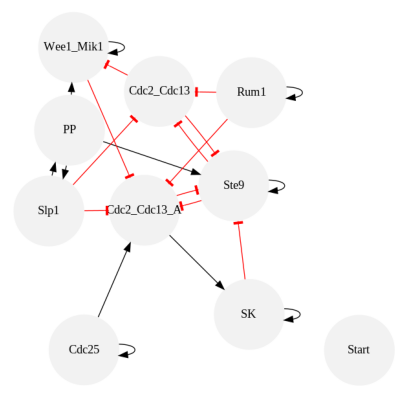

In [41]:
tasks = ["Top1", "HallofFame", "Multiprocess", "Initialization", "Initial_State"]
best = test(primes, "Top1", nodes_to_evolve=nodes_to_evolve)
report_gp_results(best[0], primes, nodes_to_evolve, f'igraph_gp_top1.svg')

Original Boolean model: {'Cdc25': 'Cdc2_Cdc13&!PP | Cdc25&!PP | Cdc25&Cdc2_Cdc13', 'Cdc2_Cdc13': '!Rum1&!Slp1&!Ste9', 'Cdc2_Cdc13_A': 'Cdc25&!Rum1&!Slp1&!Ste9&!Wee1_Mik1', 'PP': 'Slp1', 'Rum1': '!Cdc2_Cdc13_A&PP&Rum1&!SK | !Cdc2_Cdc13&PP&Rum1&!SK | !Cdc2_Cdc13&!Cdc2_Cdc13_A&Rum1&!SK | !Cdc2_Cdc13&!Cdc2_Cdc13_A&PP&!SK | !Cdc2_Cdc13&!Cdc2_Cdc13_A&PP&Rum1', 'SK': 'Start', 'Slp1': 'Cdc2_Cdc13_A', 'Start': 'False', 'Ste9': '!Cdc2_Cdc13_A&PP&!SK&Ste9 | !Cdc2_Cdc13&PP&!SK&Ste9 | !Cdc2_Cdc13&!Cdc2_Cdc13_A&!SK&Ste9 | !Cdc2_Cdc13&!Cdc2_Cdc13_A&PP&Ste9 | !Cdc2_Cdc13&!Cdc2_Cdc13_A&PP&!SK', 'Wee1_Mik1': 'PP&Wee1_Mik1 | !Cdc2_Cdc13&Wee1_Mik1 | !Cdc2_Cdc13&PP'}
Top-1 Boolean model:  {'Cdc25': 'SK&!Wee1_Mik1 | Cdc25', 'Cdc2_Cdc13': '!Rum1&!Slp1&!Ste9', 'Cdc2_Cdc13_A': 'Cdc25&!Rum1&!Slp1&!Ste9&!Wee1_Mik1', 'PP': 'Slp1', 'Rum1': 'Rum1', 'SK': 'SK | Cdc2_Cdc13_A', 'Slp1': 'PP', 'Start': 'False', 'Ste9': '!Cdc2_Cdc13_A&PP&!SK&Ste9 | !Cdc2_Cdc13&PP&!SK&Ste9 | !Cdc2_Cdc13&!Cdc2_Cdc13_A&!SK&Ste9 | !Cdc2_Cdc1

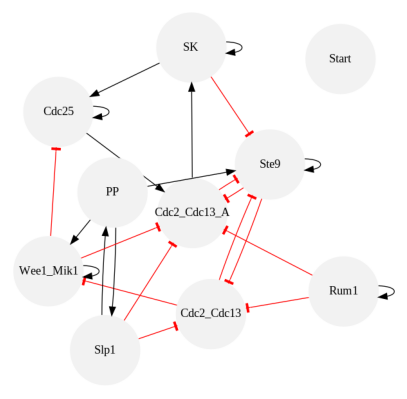

In [42]:
report_gp_results(best[2], primes, nodes_to_evolve, f'igraph_gp_second.svg')

generations:15, pop_size: 100, nodes_to_evolve: ['Cdc25', 'Rum1', 'SK', 'Slp1'], initial_state: None, initialization: None, use_topology: True
Gen 0 – best=15.869, avg=1.333, std=3.224
Best logic expression: ['Slp1&Slp1', 'SK | PP', 'Slp1 | Slp1', 'Cdc2_Cdc13_A&Cdc2_Cdc13_A']
PyBoolNet model: {'Cdc25': [[{'Slp1': 0}], [{'Slp1': 1}]], 'Cdc2_Cdc13': [[{'Ste9': 1}, {'Slp1': 1}, {'Rum1': 1}], [{'Rum1': 0, 'Slp1': 0, 'Ste9': 0}]], 'Cdc2_Cdc13_A': [[{'Wee1_Mik1': 1}, {'Ste9': 1}, {'Slp1': 1}, {'Rum1': 1}, {'Cdc25': 0}], [{'Cdc25': 1, 'Rum1': 0, 'Slp1': 0, 'Ste9': 0, 'Wee1_Mik1': 0}]], 'PP': [[{'Slp1': 0}], [{'Slp1': 1}]], 'Rum1': [[{'PP': 0, 'SK': 0}], [{'SK': 1}, {'PP': 1}]], 'SK': [[{'Slp1': 0}], [{'Slp1': 1}]], 'Slp1': [[{'Cdc2_Cdc13_A': 0}], [{'Cdc2_Cdc13_A': 1}]], 'Start': [[{}], []], 'Ste9': [[{'SK': 1, 'Ste9': 0}, {'PP': 0, 'Ste9': 0}, {'PP': 0, 'SK': 1}, {'Cdc2_Cdc13_A': 1, 'Ste9': 0}, {'Cdc2_Cdc13_A': 1, 'SK': 1}, {'Cdc2_Cdc13_A': 1, 'PP': 0}, {'Cdc2_Cdc13': 1, 'Ste9': 0}, {'Cdc2_Cd

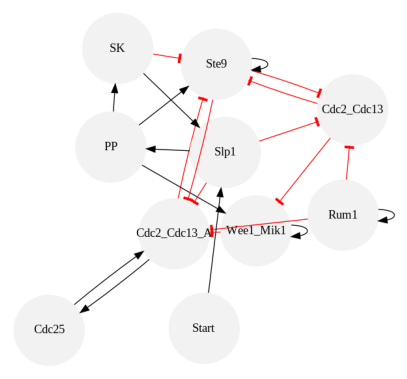

In [43]:
best_topo = test(primes, "Topology", nodes_to_evolve=nodes_to_evolve)
report_gp_results(best_topo[0], primes, nodes_to_evolve, f'igraph_gp_topology.svg')

generations:15, pop_size: 100, nodes_to_evolve: ['Cdc25', 'Rum1', 'SK', 'Slp1'], initial_state: ['0100101111', '0011000001', '0010100001', '0011100001', '0101000110', '0100100001', '0011000011', '0010100011', '0011100011'], initialization: None, use_topology: True
Gen 0 – best=18.565, avg=2.563, std=4.611
Best logic expression: ['Cdc2_Cdc13_A', 'SK | SK', '!Start', 'Rum1&PP']
PyBoolNet model: {'Cdc25': [[{'Cdc2_Cdc13_A': 0}], [{'Cdc2_Cdc13_A': 1}]], 'Cdc2_Cdc13': [[{'Ste9': 1}, {'Slp1': 1}, {'Rum1': 1}], [{'Rum1': 0, 'Slp1': 0, 'Ste9': 0}]], 'Cdc2_Cdc13_A': [[{'Wee1_Mik1': 1}, {'Ste9': 1}, {'Slp1': 1}, {'Rum1': 1}, {'Cdc25': 0}], [{'Cdc25': 1, 'Rum1': 0, 'Slp1': 0, 'Ste9': 0, 'Wee1_Mik1': 0}]], 'PP': [[{'Slp1': 0}], [{'Slp1': 1}]], 'Rum1': [[{'SK': 0}], [{'SK': 1}]], 'SK': [[{'Start': 1}], [{'Start': 0}]], 'Slp1': [[{'Rum1': 0}, {'PP': 0}], [{'PP': 1, 'Rum1': 1}]], 'Start': [[{}], []], 'Ste9': [[{'SK': 1, 'Ste9': 0}, {'PP': 0, 'Ste9': 0}, {'PP': 0, 'SK': 1}, {'Cdc2_Cdc13_A': 1, 'Ste9':

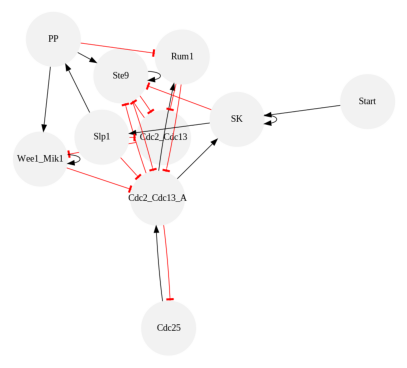

In [44]:
best_init_state = test(primes, "Initial_State", nodes_to_evolve=nodes_to_evolve, initial_state=initial_state)
report_gp_results(best_init_state[0], primes, nodes_to_evolve, f'igraph_gp_initial_state.svg')

In [45]:
# best_multi = test(primes, "Multiprocess", nodes_to_evolve=nodes_to_evolve)
# report_gp_results(best_multi[0], primes, nodes_to_evolve, f'igraph_gp_multiprocess.svg')

In [46]:
# best_init = test(primes, "Initialization", nodes_to_evolve=nodes_to_evolve, initialization=[{"Cdc25": "NOT(AND(PP, Cdc25))"}])
# report_gp_results(best_init[0], primes, nodes_to_evolve, f'igraph_gp_initialization.svg')